# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

In [1]:
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from skimage import transform
from skimage.exposure import equalize_hist, adjust_gamma
import pickle
import math
import time
from datetime import timedelta
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import seaborn as sns
import pylab as pl
import cv2
%matplotlib inline

In [2]:
# Load pickled data
# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'].astype(np.float32), train['labels'].astype(np.float32)
X_test, y_test = test['features'].astype(np.float32), test['labels'].astype(np.float32)

In [3]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


## Data Visualization

### First I am going to read in the names of the various signs in the dataset so we know what we are working with

In [3]:
label_names = pd.read_csv('signnames.csv')
label_names

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


## Now I am going to visualize the number of labels per class in the training and testing sets

In [16]:
train_labels = pd.DataFrame(y_train)
train_labels.columns=['ClassId']
train_labels = train_labels.merge(label_names, how='inner', on = 'ClassId')
train_labels['ClassId'] = train_labels['ClassId'].astype(np.int64)
train_grouped = train_labels.groupby(['SignName']).count().astype(np.int64)
train_grouped

,ClassId
SignName,
Ahead only,1200
Beware of ice/snow,450
Bicycles crossing,270
Bumpy road,390
Children crossing,540
Dangerous curve to the left,210
Dangerous curve to the right,360
Double curve,330
End of all speed and passing limits,240


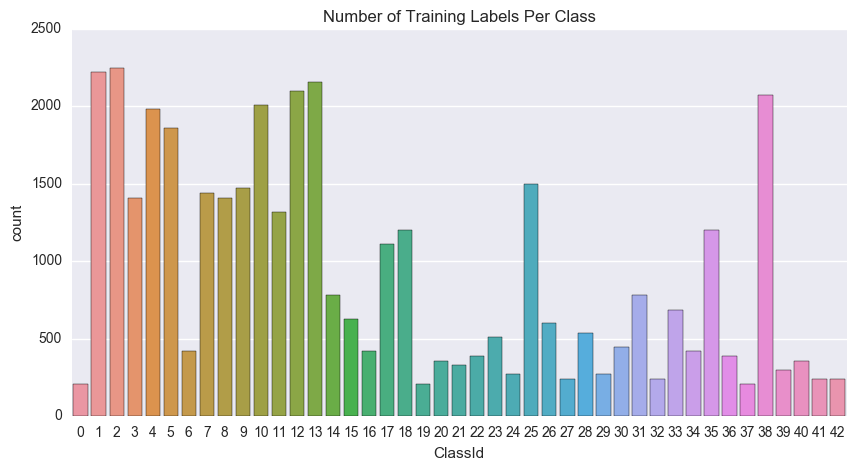

In [64]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
sns.countplot(x = 'ClassId', data=train_labels);
pl.title('Number of Training Labels Per Class');

In [68]:
test_labels = pd.DataFrame(y_test)
test_labels.columns=['ClassId']
test_labels = test_labels.merge(label_names, how='inner', on = 'ClassId')
test_labels['ClassId'] = test_labels['ClassId'].astype(np.int64)
test_labels.groupby(['SignName']).count()

,ClassId
SignName,
Ahead only,390
Beware of ice/snow,150
Bicycles crossing,90
Bumpy road,120
Children crossing,150
Dangerous curve to the left,60
Dangerous curve to the right,90
Double curve,90
End of all speed and passing limits,60


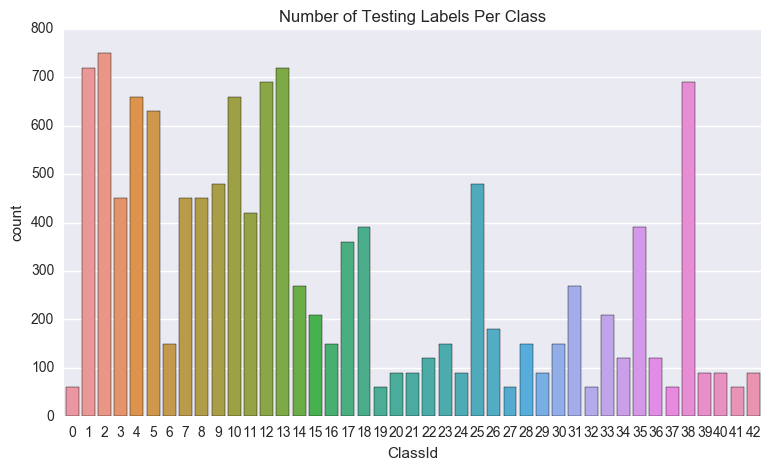

In [69]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 5)
sns.countplot(x = 'ClassId', data=test_labels);
pl.title('Number of Testing Labels Per Class');

### Now I will randomly select five sample images from the training dataset, I will identify what class of sign each one is, and then I will visualize each sign so we can get start to see what the images in the dataset are like.

In [112]:
sample_index1 = np.random.randint(len(X_train))
sample_image1 = X_train[sample_index1]
sample_index2 = np.random.randint(len(X_train))
sample_image2 = X_train[sample_index2]
sample_index3 = np.random.randint(len(X_train))
sample_image3 = X_train[sample_index3]
sample_index4 = np.random.randint(len(X_train))
sample_image4 = X_train[sample_index4]
sample_index5 = np.random.randint(len(X_train))
sample_image5 = X_train[sample_index5]

In [102]:
label_names[label_names['ClassId'] == y_train[sample_index1]]

,ClassId,SignName
12,12,Priority road


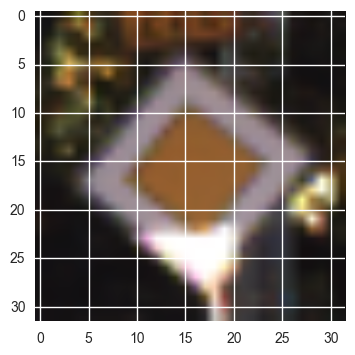

In [103]:
plt.figure();
plt.imshow(sample_image1.astype('uint8'));

In [104]:
label_names[label_names['ClassId'] == y_train[sample_index2]]

,ClassId,SignName
13,13,Yield


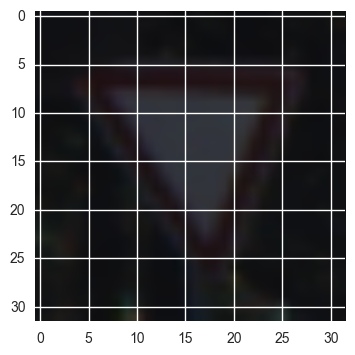

In [105]:
plt.figure();
plt.imshow(sample_image2.astype('uint8'));

In [106]:
label_names[label_names['ClassId'] == y_train[sample_index3]]

,ClassId,SignName
5,5,Speed limit (80km/h)


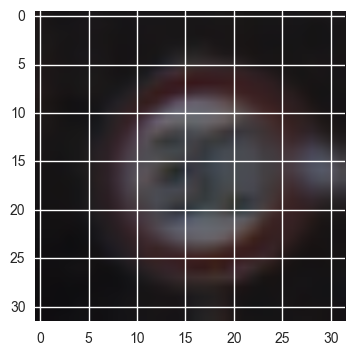

In [107]:
plt.figure();
plt.imshow(sample_image3.astype('uint8'));

In [113]:
label_names[label_names['ClassId'] == y_train[sample_index4]]

,ClassId,SignName
10,10,No passing for vechiles over 3.5 metric tons


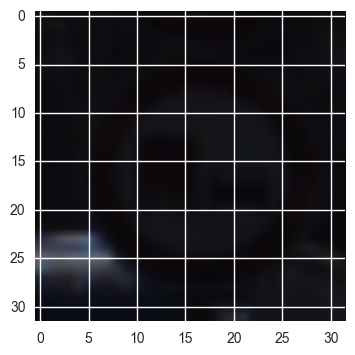

In [114]:
plt.figure();
plt.imshow(sample_image4.astype('uint8'));

In [110]:
label_names[label_names['ClassId'] == y_train[sample_index5]]

,ClassId,SignName
7,7,Speed limit (100km/h)


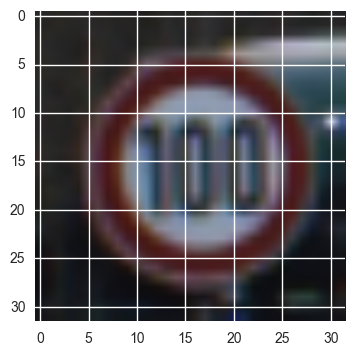

In [111]:
plt.figure();
plt.imshow(sample_image5.astype('uint8'));

#### From visualizing the images, it is apparent that they are very low resolution and appear to be quite blurry. There are several instances where the human eye could even have trouble identifying what type of traffic sign a given image is, so it will be interesting to see what the deep learning model will be able to accomplish in terms of accuracy in classifying the signs. In the next section I will perform some preprocessing on the image data in hopes of making the images more recognizable.

## Data Preprocessing

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

#### The first stop in preprocessing the data will be to randomize the training and testing datasets to make sure that they are not in any kind of order which could be memorized by the deep learning model

In [4]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
X_train, y_train = randomize(X_train, y_train)
X_test, y_test = randomize(X_test, y_test)

#### The next thing I will do in preprocessing is to increase the contrast of the contrast and pixel intensity of the images using histogram equalization and gamma adjustment. The purpose of these adjustments is to provide increased detail in images which are over of under exposed, hopefully making them easier to identify by the deep learning model.

In [5]:
X_train = equalize_hist(X_train)
X_train = adjust_gamma(X_train)
#X_train = adjust_log(X_train)

In [6]:
X_test = equalize_hist(X_test)
X_test = adjust_gamma(X_test)
#X_test = adjust_log(X_test)

#### The next step is to one-hot encode the labels

- One hot encoding is a necessary step because it converts the values of the labels to a vector of length n_classes, matching the shape of the output of the softmax function in the deep learning model.

In [7]:
encoder = LabelBinarizer()
encoder.fit(y_train)
y_test = encoder.transform(y_test)
y_train = encoder.transform(y_train)

#### Next I am going to normalize the training and testing data by subtracting the mean from the data and then dividing it by the standard deviation. The result of this will be data which has a very small mean (close to zero) and equal variance.

- This step is important because the deep learning model will produce the best results when it is trained on data which has zero mean and equal variance.

In [8]:
print(np.mean(X_train), np.std(X_train))
print(np.mean(X_test), np.std(X_test))

0.502229417261 0.290334890351
0.502197312391 0.290252790483


In [9]:
X_test -= np.mean(X_test)
X_test /= np.std(X_test)
X_train -= np.mean(X_train)
X_train /= np.std(X_train)

In [10]:
print(np.mean(X_train), np.std(X_train))
print(np.mean(X_test), np.std(X_test))

3.93193015626e-15 1.0
1.42534000789e-15 1.0


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

- I held out 10 percent of the training data to use for validation, and the final accuracy score was determined by running the model on the provided test dataset.

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .1, random_state = 123)

In [12]:
# Make sure the data is the correct type and shape
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)
print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_val.shape, y_val.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (35288, 32, 32, 3) (35288, 43)
Validation set (3921, 32, 32, 3) (3921, 43)
Test set (12630, 32, 32, 3) (12630, 43)


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### In addition to the images in the training and testing data sets, I have taken some additional pictures of traffic signs and I will check how the model does in attempting to classify them. 

- The first image is of a regular stop sign. Stop signs are fairly well represented in the training data so I am predicting that the model should have no problem correctly classifying this image. 

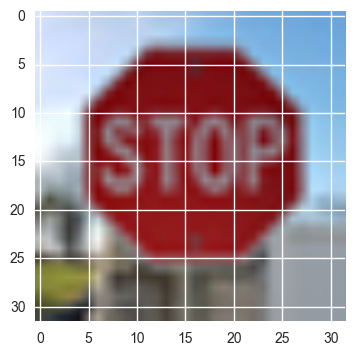

In [2]:
stop = mpimg.imread('images/stop.jpg')
plt.imshow(stop);

In [84]:
stop = stop.astype(np.float32)
stop -= np.mean(stop)
stop /= np.std(stop)
stop = stop.reshape(-1, 32, 32, 3)
stop.shape

(1, 32, 32, 3)

- My second additional image is of a yield sign. Yield signs are actually even more abundant than stop signs in the training dataset so I predict that the model will correctly classify this image with very high confidence.

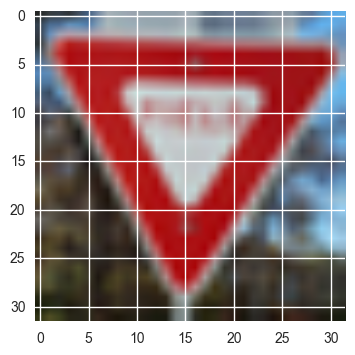

In [3]:
y = mpimg.imread('images/yield.jpg')
plt.imshow(y);

In [86]:
y = y.astype(np.float32)
y -= np.mean(y)
y /= np.std(y)
y = y.reshape(-1, 32, 32, 3)
y.shape

(1, 32, 32, 3)

- My third additional image is of a speed limit 30 sign. I am interested to see how this one will be classified because, although speed limit 30 signs to exist in the training data, the ones in the dataset are the european style which are a different shape and don't actually contain the words "speed limit". 

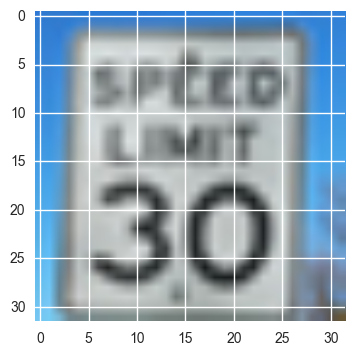

In [87]:
thirty =  mpimg.imread('images/30.jpg')
plt.imshow(thirty);

In [88]:
thirty =  thirty.astype(np.float32)
thirty -= np.mean(thirty)
thirty /= np.std(thirty)
thirty = thirty.reshape(-1, 32, 32, 3)

- My fourth additional image is of a speed limit 25 sign. I have chosen this sign as an experiment to see what will happen when I feed the model an image which does not exist in the training dataset. Not only are the US and European speed limit signs shaped differently, there are no speed limit 25 signs at all in the dataset, so there is no way that the model will be able to correctly identify this particular sign.

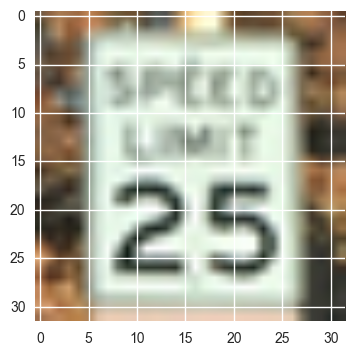

In [89]:
twenty_five =  mpimg.imread('images/25.jpg')
plt.imshow(twenty_five);

In [90]:
twenty_five =  twenty_five.astype(np.float32)
twenty_five -= np.mean(twenty_five)
twenty_five /= np.std(twenty_five)
twenty_five = twenty_five.reshape(-1, 32, 32, 3)
twenty_five.shape

(1, 32, 32, 3)

- My fifth and final additional sign is a "Do Not Enter" sign. The training dataset contains "No Entry" signs which are basically the same as this and I am expecting that the model will be able to correctly classify this image as a no entry sign.

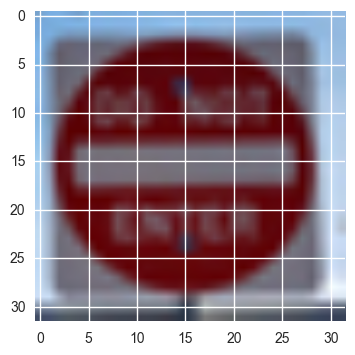

In [91]:
do_not_enter =  mpimg.imread('images/do_not_enter.jpg')
plt.imshow(do_not_enter);

In [92]:
do_not_enter =  do_not_enter.astype(np.float32)
do_not_enter -= np.mean(do_not_enter)
do_not_enter /= np.std(do_not_enter)
do_not_enter = do_not_enter.reshape(-1, 32, 32, 3)
do_not_enter.shape

(1, 32, 32, 3)

In [93]:
batch_size = 32
image_size = 32
num_labels = 43
num_channels = 3
patch_size = 5
depth = 24
num_hidden = 256
beta = .0005

graph = tf.Graph()

with graph.as_default():
    
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(None, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels))
    tf_valid_dataset = tf.constant(X_val)
    tf_test_dataset = tf.constant(X_test)
    
    layer1_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, num_channels, depth], stddev=0.05))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, depth, depth], stddev=0.05))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal(
        [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.05))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.05))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
    def model(data):
        conv = tf.nn.dropout(tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME'),0.8)
        hidden = tf.nn.relu(conv + layer1_biases)
        pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        shape = pool.get_shape()
        num_features = shape[1:4].num_elements()
        layer_flat = tf.reshape(pool, [-1, num_features])
        hidden = tf.nn.relu(tf.matmul(layer_flat, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases
    
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    loss += beta * (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer1_biases)
                  + tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer2_biases)
                  + tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer3_biases)
                  + tf.nn.l2_loss(layer4_weights) + tf.nn.l2_loss(layer4_biases)) 
    
    global_step = tf.Variable(0)  
    learning_rate = tf.train.exponential_decay(0.05, global_step * batch_size, y_train.shape[0], .95)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=global_step)
    
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))
    stop_sign = tf.constant(stop)
    stop_pred = tf.nn.softmax(model(stop_sign))
    yield_sign = tf.constant(y)
    yield_pred = tf.nn.softmax(model(yield_sign))
    thirty = tf.constant(thirty)
    thirty_pred = tf.nn.softmax(model(thirty))
    twenty_five = tf.constant(twenty_five)
    twenty_five_pred = tf.nn.softmax(model(twenty_five))
    do_not_enter = tf.constant(do_not_enter)
    do_not_enter_pred = tf.nn.softmax(model(do_not_enter))

In [71]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Initialized
Minibatch loss at step 0: 4.584300
Minibatch accuracy: 0.0%
Validation accuracy: 6.3%
Minibatch loss at step 600: 0.815476
Minibatch accuracy: 84.4%
Validation accuracy: 86.9%
Minibatch loss at step 1200: 0.334617
Minibatch accuracy: 100.0%
Validation accuracy: 95.6%
Minibatch loss at step 1800: 0.306248
Minibatch accuracy: 100.0%
Validation accuracy: 97.7%
Minibatch loss at step 2400: 0.292562
Minibatch accuracy: 100.0%
Validation accuracy: 98.2%
Minibatch loss at step 3000: 0.279566
Minibatch accuracy: 100.0%
Validation accuracy: 98.6%
Minibatch loss at step 3600: 0.288732
Minibatch accuracy: 100.0%
Validation accuracy: 98.1%
Minibatch loss at step 4200: 0.270764
Minibatch accuracy: 100.0%
Validation accuracy: 98.4%
Minibatch loss at step 4800: 0.267211
Minibatch accuracy: 100.0%
Validation accuracy: 98.9%
Minibatch loss at step 5400: 0.259970
Minibatch accuracy: 100.0%
Validation accuracy: 98.9%
Minibatch loss at step 6000: 0.254477
Minibatch accuracy: 100.0%
Validation 

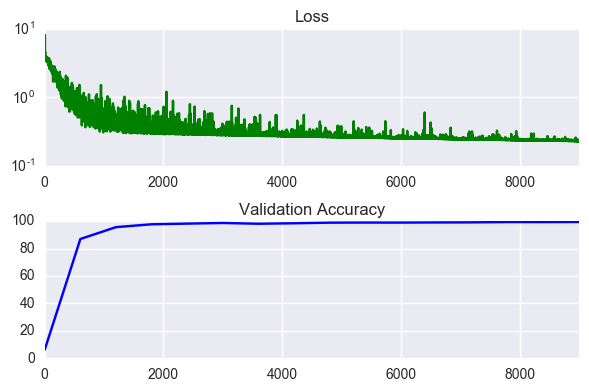

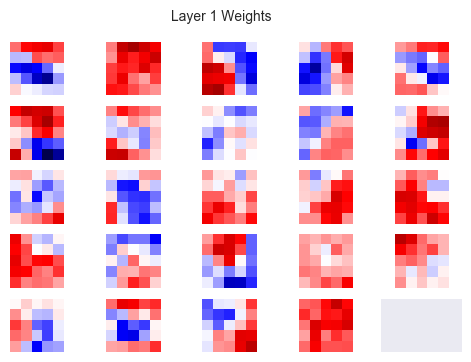

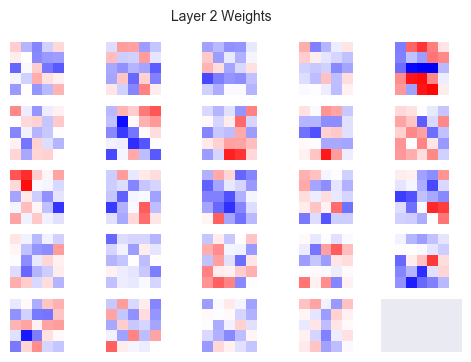

In [94]:
num_steps = 9001
batches = []
steps = []
loss_batch = []
val_acc_batch = []

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        batches.append(step)
        batch_data = X_train[offset:(offset + batch_size), :, :, :]
        batch_labels = y_train[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        loss_batch.append(l)
        if (step % 600 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            #print(predictions)
            valid_accuracy = accuracy(valid_prediction.eval(), y_val)
            val_acc_batch.append(valid_accuracy)
            steps.append(step)
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % valid_accuracy)
    test_pred = test_prediction.eval()
    print('Test accuracy: %.1f%%' % accuracy(test_pred, y_test))
    stop_pred = stop_pred.eval()
    yield_pred = yield_pred.eval()
    thirty_pred = thirty_pred.eval()
    twenty_five_pred = twenty_five_pred.eval()
    do_not_enter_pred = do_not_enter_pred.eval()
    loss_plot = plt.subplot(211)
    loss_plot.set_title('Loss')
    loss_plot.plot(batches, loss_batch, 'g')
    loss_plot.set_xlim(0, num_steps)
    loss_plot.set_yscale('log')
    acc_plot = plt.subplot(212)
    acc_plot.set_title('Validation Accuracy')
    acc_plot.plot(steps, val_acc_batch, 'b')
    acc_plot.set_xlim(0, num_steps)
    plt.tight_layout()
    plt.show()
    
    w = session.run(layer1_weights)
    w_min = np.min(w)
    w_max = np.max(w)
    num_filters = w.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)
    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = w[:, :, 0, i]
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.suptitle('Layer 1 Weights')
    plt.show()
    
    w2 = session.run(layer2_weights)
    w_min = np.min(w2)
    w_max = np.max(w2)
    num_filters = w2.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)
    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = w2[:, :, 0, i]
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.suptitle('Layer 2 Weights')
    plt.show()

### Results from running the model:

- The accuracy of predictions made on the training dataset increased quickly and hovered between 99-100% for most of the training duration.

- The validation accuracy was consistently slightly lower than the minibatch training accuracy but still was very high and seemed to level out around 99%

- The test accuracy was 92.9%, which was lower than both the training and validation accuracy. This means that the model is overfitting to the training data and is less robust in making predictions on new data which it was not trained on. 

### Now I will produce a confusion matrix of the predictions on the test dataset and see where the majority of incorrect classifications were coming from

In [95]:
from sklearn.metrics import confusion_matrix
preds = np.argmax(test_pred, axis=1)
cm = pd.DataFrame(confusion_matrix(encoder.inverse_transform(y_test), preds))
cm.columns=(label_names['SignName'])
cm.index=(label_names['ClassId'])
cm

SignName,Speed limit (20km/h),Speed limit (30km/h),Speed limit (50km/h),Speed limit (60km/h),Speed limit (70km/h),Speed limit (80km/h),End of speed limit (80km/h),Speed limit (100km/h),Speed limit (120km/h),No passing,No passing for vechiles over 3.5 metric tons,Right-of-way at the next intersection,Priority road,Yield,Stop,No vechiles,Vechiles over 3.5 metric tons prohibited,No entry,General caution,Dangerous curve to the left,Dangerous curve to the right,Double curve,Bumpy road,Slippery road,Road narrows on the right,Road work,Traffic signals,Pedestrians,Children crossing,Bicycles crossing,Beware of ice/snow,Wild animals crossing,End of all speed and passing limits,Turn right ahead,Turn left ahead,Ahead only,Go straight or right,Go straight or left,Keep right,Keep left,Roundabout mandatory,End of no passing,End of no passing by vechiles over 3.5 metric tons
ClassId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,43,16,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,696,11,0,3,0,0,1,2,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
2,0,10,730,5,1,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,431,0,15,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1,25,2,1,612,2,0,11,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,10,16,29,6,535,0,16,8,0,0,0,0,5,0,3,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,11,110,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,1,0,0,1,6
7,0,2,2,4,0,7,0,394,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,2,0,7,0,2,0,3,422,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,2,0,0,0,0


- From looking at the confusion matrix, it can be seen that many of the incorrect classifications came from speed limit signs being identified as other speed limit signs. 
- There also seemed to be some confusion from other signs being classified as "General Caution", which is a slightly ambiguous category.
- Overall, many of the categories contain a very high percentage of correct classifications including stop signs which were classified correctly 270 times out of 270.

## Now let's see what the additional images were classified as, as well as the top 5 predictions for each sign.

### Stop Sign

In [96]:
label_names[label_names['ClassId'] == np.argmax(stop_pred)]

,ClassId,SignName
14,14,Stop


- The picture of a stop sign was correctly classified as a stop sign

In [97]:
stop_df = pd.DataFrame(stop_pred)
stop_df.columns=(label_names['SignName'])
stop_df = stop_df.transpose()
stop_df.sort_values(by=0, ascending=False).head()

,0
SignName,
Stop,9.999981e-01
No entry,1.957410e-06
No vechiles,8.945118e-09
Speed limit (80km/h),1.021229e-09
Road work,6.331480e-10


- The softmax probability of the stop sign prediction is .9999981, which means the model was basically 100% sure of it's prediction, and the chance of it being any other type of sign is extremely small.
- This high confidence is not surprising because the model correctly classified 100% of stop sign examples in the test set.

### Yield Sign

In [98]:
label_names[label_names['ClassId'] == np.argmax(yield_pred)]

,ClassId,SignName
13,13,Yield


- The yield sign was correctly classified as a yield sign.

In [99]:
yield_df = pd.DataFrame(yield_pred)
yield_df.columns=(label_names['SignName'])
yield_df = yield_df.transpose()
yield_df.sort_values(by=0, ascending=False).head()

,0
SignName,
Yield,1.000000e+00
No passing,2.605481e-14
Speed limit (60km/h),6.752124e-18
End of no passing,4.769481e-21
Bicycles crossing,2.805064e-21


- The softmax probability for the yield sign classification is 1.0, which means that just like the stop sign, the model is extremely confident about this prediction.
- Like the stop sign, this high level of confidence is not surprising because the yield signs in the test set were correctly classified 717 out of 720 times.

### Do Not Enter

In [100]:
label_names[label_names['ClassId'] == np.argmax(do_not_enter_pred)]

,ClassId,SignName
17,17,No entry


- The "Do Not Enter" sign was classified as "No Entry" which I will consider to be a correct classification.

In [101]:
do_not_enter_df = pd.DataFrame(do_not_enter_pred)
do_not_enter_df.columns=(label_names['SignName'])
do_not_enter_df = do_not_enter_df.transpose()
do_not_enter_df.sort_values(by=0, ascending=False).head()

,0
SignName,
No entry,9.999999e-01
Speed limit (20km/h),8.807667e-08
Stop,1.887565e-08
Speed limit (30km/h),9.640005e-09
Speed limit (120km/h),2.076011e-10


- The softmax probability for this prediction is .999999 which means that the model is very confident in it's prediction.
- In the test set, No entry signs were only classified correctly in 320 out of 360 cases, which is an overlal accuracy of 88.9%, lower than the average for the whole test set. This makes it slightly surprising that the Do not enter sign was classified with such high confidence.

### Speed Limit 25

In [102]:
label_names[label_names['ClassId'] == np.argmax(twenty_five_pred)]

,ClassId,SignName
41,41,End of no passing


- The speed limit 25 sign was incorrectly classified as, "end of no passing".
- This is not a surprising result because the training dataset does not include any speed limit 25 signs so there was no way it would correctly classify this sign.

In [103]:
twenty_five_df = pd.DataFrame(twenty_five_pred)
twenty_five_df.columns=(label_names['SignName'])
twenty_five_df = twenty_five_df.transpose()
twenty_five_df.sort_values(by=0, ascending=False).head()

,0
SignName,
End of no passing,0.950279
Roundabout mandatory,0.040768
End of speed limit (80km/h),0.003142
Dangerous curve to the right,0.003106
End of no passing by vechiles over 3.5 metric tons,0.002037


- The softmax probability of the prediction was .950279 which is a fairly high confidence for an incorrect classification. 
- It was also given a 4% probability of being a "Roundabout Mandatory" sign, a .3% chance of being an "End of speed limit 80" sign, a .3% chance of being a "Dangerous curve to the right" sign and a .2% chance of being an "End of no passing by vechiles over 3.5 metric tons" sign.

### Speed Limit 30

In [104]:
label_names[label_names['ClassId'] == np.argmax(thirty_pred)]

,ClassId,SignName
20,20,Dangerous curve to the right


- The speed limit 30 sign was incorrectly classified as a "Dangerous curve to the right" sign.
- Again, this is not entirely surprising because the US speed limit signs are different than the european ones which were used in training, so this was the first time that the model had been introduced to this kind of sign.

In [105]:
thirty_df = pd.DataFrame(thirty_pred)
thirty_df.columns=(label_names['SignName'])
thirty_df = thirty_df.transpose()
thirty_df.sort_values(by=0, ascending=False).head()

,0
SignName,
Dangerous curve to the right,0.664360
Children crossing,0.302555
Traffic signals,0.015482
General caution,0.012249
Speed limit (100km/h),0.003344


- The softmax probability for this prediction is 0.664360 which is not quite as significantly less certain than the other predictions.
- It was also given a 30% chance of being a "Children Crossing" sign and a 1.5% chance of being"Traffic Signals".
- If there is any class which would be considered a correct prediction for this sign it would be a sped limit 30 km/h sign but unfortunately that sign has not appeared in the top 5 results.

##### The model was able to correctly classify 3 out of the 5 additional images, and it was correct in classifying all of the images that I expected it would be able to.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._

**Answer:**

the architecture of my model is as follows:

- Layer 1: Dropout (0.8 keep prob) >> Convolution ([1,1,1,1] strides) >> ReLu >> Max Pooling (2 x 2). Layer 1 shape = (?, 16, 16, 24)

- Layer 2: Convolution ([1,1,1,1] strides) >> ReLu >> Max Pooling (2 x 2). Layer 2 shape = (?, 8, 8, 24)

- Layer 3: Flatten >> ReLu. Layer 3 shape = (?, 256)

- Layer 4: Softmax Activation. Layer 4 shape = (?, 43)

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

- To train the model I used a Gradient Descent Optimizer, with a decaying learning rate starting at 0.05. 

- In training, I used a batch size of 32 images, and ran through 9001 batches, which is just over 8 epochs, before evaluating the test accuracy. The batch size and number of epochs were chosen because I was running the model on a CPU and these numbers gave a decent trade-off between test accuracy and training time.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

To solve this problem, I began by reviewing previous deep learning projects I had completed in my coursework at Udacity: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/4_convolutions.ipynb https://github.com/udacity/CarND-TensorFlow-Lab and I adapted the models used for those projects to suit this particular problem. 

I made the decision to build a convulutional neural network (convnet) because this is an image classification problem and I wanted to maintain the spatial structure of the images, and the relationships between adjacent pixels. Convolutional neural networks avoid the problem of having to flatten the images in to a 1 dimensional vector and are therefore more powerful in recongnizing 2 dimensional images.

As far as tuning hyperparameters goes, it was really by trial and error as much as anything else and I have not exhausted every parameter combination because I did not use a GPU in training and training was slow.

The parameters which were tested were:
- Learning rate and it's decay rate
- Number of layers
- Size of each layer
- Type of optimizer (SGD, Adam, Momentum Optimizer)

The steps that I would take to further improve the performance would include switching to a GPU so that I could programmatically test different hyperparameter combinations and augmenting the dataset with additional images from the under represented classes which should help to combat the overfitting of the training data.

## Additional References:

https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb 

https://en.wikipedia.org/wiki/Convolutional_neural_network

http://machinelearningmastery.com/crash-course-convolutional-neural-networks/